# Starbucks Capstone Challenge

<br>
<br>

<img src='images/st02.png' width = 400>

<br>

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

<br>

<img src='images/st04.jpg' width = 700>

<br>

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="images/pic1.png"/>

Then you will want to run the above command:

<img src="images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1) Loading required packages and reading in the files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


# 2) Data wrangling

<img src="images/woolball.jpg" width = 500/>

## Portfolio

We start by examining portfolio, the smallest of the files:

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We see that portfolio only has ten rows of data, corresponding to each different offers clasified in three kind of offers:
    
* bogo --> buy one, get one. Four offers, divided into two subkinds with different rewards (10 and 5, pressumably corresponding to 1 + 1 for free and 2 + 1 offers)

* discount --> Four different kind of offers, with rewards of 5, 3, 2 and 2 again (50, 30 and 20%?)

* informational --> two offers, 0 reward (information emails, we pressume)

Beyond that, we observe that we have also information on different difficulties and durations for each offer, and also information on which channels was this offer offered.

We need little manipulation: we will just divide the channel column into four, with ones when the corresponding channel was used and zeros when it did not:

In [6]:
new_columns = ['web', 'email', 'mobile', 'social']

for value in new_columns:
    portfolio[value] = portfolio['channels'].apply(lambda x: 1 if value in x else 0)

And drop the original column:

In [7]:
portfolio.drop('channels', axis = 1, inplace = True)

## Profile

Let's see what Profile has to offer:

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


We define a function that we will use to describe this and the following datasets:

In [9]:
def describing_fun(df):
    print(df.info())
    print(df.describe())
    
    print("\nValue counts:\n")
    
    for col in df:
    
        length = len(df[col].unique())

        if length < 7:
            print(col, ":", length, ', which are:', df[col].unique())
        else:
            print(col, ":", length)

In [10]:
describing_fun(profile)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
None
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

Value counts:

age : 85
became_member_on : 1716
gender : 4 , which are: [None 'F' 'M' 'O']
id : 17000
income : 92


It seems that some values are missing.

Let's check those missing values:

In [11]:
profile.isnull().any(axis = 1).sum()

2175

In [12]:
profile[profile.isnull().any(axis = 1)].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [13]:
profile[profile.isnull().any(axis = 1)]['age'].unique()

array([118], dtype=int64)

All nulls present in any columns are associated with people 118 years old, probably a code used to describe this people.

We will drop this values. But first, we will also parse the dates correctly:

In [14]:
profile['date_bmo'] = profile['became_member_on'].apply(lambda x: dt.datetime.strptime(str(x), "%Y%m%d"))

In [15]:
profile['year_bmo'] = profile['date_bmo'].apply(lambda x: x.year)
profile['month_bmo'] = profile['date_bmo'].apply(lambda x: x.month)
profile['day_bmo'] = profile['date_bmo'].apply(lambda x: x.day)

# Removing the original untreated column:
profile.drop('became_member_on', axis=1, inplace=True)

# Extracting a new feature: client's seniority:
# We assume the date of the latest client as point of origin:
profile['seniority'] = (profile['date_bmo'].max() - profile['date_bmo']).dt.days

And now, we drop the NaNs:

In [16]:
clean_profile = profile.dropna()

Let's see ill all went well (sanity check):

In [17]:
# Should be 17000 - 2125 = 14825:
print(len(clean_profile))

clean_profile.head()

14825


,age,gender,id,income,date_bmo,year_bmo,month_bmo,day_bmo,seniority
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,7,15,376
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,5,9,443
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,2018,4,26,91
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,2018,2,9,167
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,2017,11,11,257


We do it in a separate table for two reasons:

* So we don't mess with our original loaded table.

* So we don't loose the information those rows do provide: it shows when they became members.

As long as we have enough memory, it feels right to create a new table for this manipulation.

We will have to drop all values related to these clients also in the transcript df later.

Finally, we will check for duplicates:

In [18]:
profile[profile.duplicated()]

,age,gender,id,income,date_bmo,year_bmo,month_bmo,day_bmo,seniority


Perfect, no duplicates.

## Transcript

We now go for transcript. This is the biggest and more complicated df:

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


We see we will have to split again those values in a dictionary.

But first, let's look for NaN's:

In [20]:
transcript.isna().any().sum()

0

And now, we will mark all customers which we already dropped in the clean_profile table:

In [21]:
# For comfort's sake we will rename the 'person' column to 'id', so merges are faster to write:
transcript.rename({'person' : 'id'}, axis = 1, inplace = True)

We see that all values in the transcript table pertained to clients of which we had a profile, whether complete or incomplete:

In [22]:
len(transcript[~transcript['id'].isin(profile['id'])])/len(transcript)

0.0

Let's see how many rows these customers with missing information represent:

In [23]:
len(transcript[~transcript['id'].isin(clean_profile['id'])])/len(transcript)

0.11017374907840566

Their weight on the offers is slightly less than that of the rest of the users (as they represented 12.5% of our customer base, but only 11% of the transactions).

We will also drop those transactions, creating a new table, because of the same reasons stated above, but we will do it a bit later.

Ok, now we will go for the dictionary:

In [24]:
# Let's look at the keys:

def mi_keys(x):
    for key in x.keys():
        return key

In [25]:
transcript['value'].apply(mi_keys).unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

We see there are only 3 different values, that should be 2.

We will fix that 'offer id' vs 'offer_id' thing:

In [26]:
# This function will clean the dictionary column:
def clean_col(x):
    for key in x.keys():
        if key == 'offer id':
            x['offer_id'] = x[key]
            del x[key]
            return x
        else:
            return x

In [27]:
transcript['value'] = transcript['value'].apply(clean_col)

And now, we are going to separate the different values of the dictionary into their own columns:

In [28]:
transcript2 = pd.concat([transcript[['event', 'id', 'time']], 
                         pd.DataFrame((d for idx, d in transcript['value'].iteritems()))], 
                        axis = 1)

In [29]:
transcript2.head()

,event,id,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Even though it doesn't look like it, it is much better now.

We will translate the 'event' column into numbers:

In [30]:
event_dict = dict(zip(transcript2['event'].unique(), [0, 1, -1, 2]))
# offer_dict = dict(zip(portfolio['id'], portfolio['offer_type']))

# transcript2['offer_type'] = transcript2['offer_id'].apply(lambda x: 0 if x != x else offer_dict[x])
transcript2['event_num'] = transcript2['event'].apply(lambda x: 0 if x != x else event_dict[x])

We are now going to check for duplicates:

In [31]:
print(len(transcript2[transcript2.duplicated()]))
transcript2[transcript2.duplicated()].head()

397


,event,id,time,amount,offer_id,reward,event_num
66123,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,2
66783,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,2
67614,offer completed,a7dc060f6fc94ca7bf71fbb188187dca,168,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,2
68562,offer completed,30478a4c1e884a63a822aa87b833ed7a,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,2
69218,offer completed,84fb57a7fe8045a8bf6236738ee73a0f,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,2


There are some... Let's put them face:

In [32]:
transcript2[(transcript2['offer_id'] == '2906b810c7d4411798c6938adc9daaa5')&
            (transcript2['id'] == '3dde94fa581145cb9f206624f1a94d5a')]

,event,id,time,amount,offer_id,reward,event_num
1098,offer received,3dde94fa581145cb9f206624f1a94d5a,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0
54262,offer received,3dde94fa581145cb9f206624f1a94d5a,168,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0
66122,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,2
66123,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,2


In [33]:
transcript2[(transcript2['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd')&
            (transcript2['id'] == 'e9fb6ed2cecb4980ba98c86abc9c91e3')]

,event,id,time,amount,offer_id,reward,event_num
3258,offer received,e9fb6ed2cecb4980ba98c86abc9c91e3,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0
41108,offer viewed,e9fb6ed2cecb4980ba98c86abc9c91e3,96,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1
56494,offer received,e9fb6ed2cecb4980ba98c86abc9c91e3,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0
66782,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,2
66783,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,2
81889,offer viewed,e9fb6ed2cecb4980ba98c86abc9c91e3,204,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1


It seems that some users got several offers at differents momments, but they all got cancelled at the same time, and that is what this duplicates make reference to.

Let's keep these values for now, and we will see how to deal with them later, if necessary.

Now, we are going to check what do the informational offers look like within the transcript dataframe:

In [34]:
informational_offers = transcript2[transcript2['offer_id'].isin(portfolio[portfolio['offer_type']=='informational']['id'])]

print(informational_offers['event'].unique())
print(informational_offers['reward'].unique())
print(informational_offers['event'].count())
informational_offers.head()

['offer received' 'offer viewed']
[nan]
26066


,event,id,time,amount,offer_id,reward,event_num
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0
31,offer received,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0
44,offer received,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0
53,offer received,6e04a90a0e074496b5f229eb1f553433,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0


As we can see, and accordingly with the spirit of those offers (just informational communications), not a single one of them has an associated 'offer completed' status nor a reward, meaning those offers cannot be completed.

As we are interested in calculating percentage ratios or offers redeemed, it seems misleading to keep these kind of offers, that are not intended to neither cannot be redeemed, and perform calculations with them.

Now we take the design decission of not bringing these offers into our models, and so, we will drop them:

In [35]:
transcript2 = transcript2[~transcript2['offer_id'].isin(portfolio[portfolio['offer_type']=='informational']['id'])]

Finally... It makes sense that the amount and offer_id present lots of values (in fact, where there is an amount there isn't an offer).

This is because it has been packed together two kind of operations of different nature.

Instead, some of the NaNs in the reward column make less sense. Those associated with an offer_id will be replaced by zeroes (but not those corresponding to transactions):

In [36]:
non_null_offer_id_indexes = transcript2[~transcript2['offer_id'].isna()].index
transcript2.loc[non_null_offer_id_indexes, 'reward'] = 0

## 3) EDA

<img src="images/detective.jpeg" width = 500/>

Up to this point, we have made some arrangements, which enable us to extract our first insights from the data.

Thus, we will now perform now some light exploratory data analysis and present some visualizations.

Firstly, we are going to plot the evolution of new monthly users. This is the reason we haven't dropped the users on the original table above:

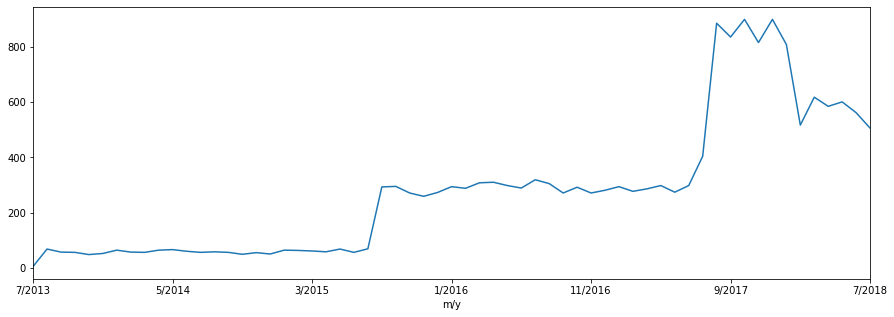

In [37]:
monthly_new_users = profile.groupby(['year_bmo', 'month_bmo'])['age'].count().reset_index()
monthly_new_users.rename({'age':'new_users_count'}, axis = 1, inplace = True)
monthly_new_users['m/y'] = monthly_new_users['month_bmo'].apply(lambda x: str(x)) + '/' + monthly_new_users['year_bmo'].apply(lambda x: str(x))
monthly_new_users.set_index('m/y', inplace = True)

monthly_new_users['new_users_count'].plot(figsize = [15,5]);

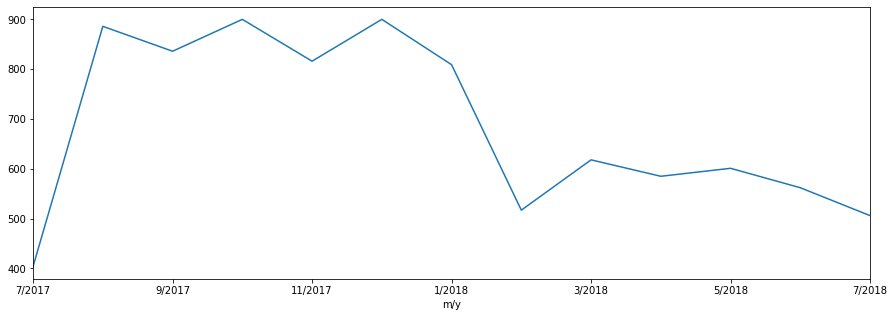

In [38]:
monthly_new_users['7/2017':]['new_users_count'].plot(figsize = [15,5]);

We can see that there have been four different phases in our customer base growth:

* one initial phase, long ago, in which few people registered
* one intermediate phase, from about year -3 to year -1, with bigger growth
* continued by a phase of explosion
* and a last phase of less great growth, but bigger than in phases 1 and 2

We can see a clear spike or explosion in the number of new clients during our third phase from August of 2017 to January of 2018.

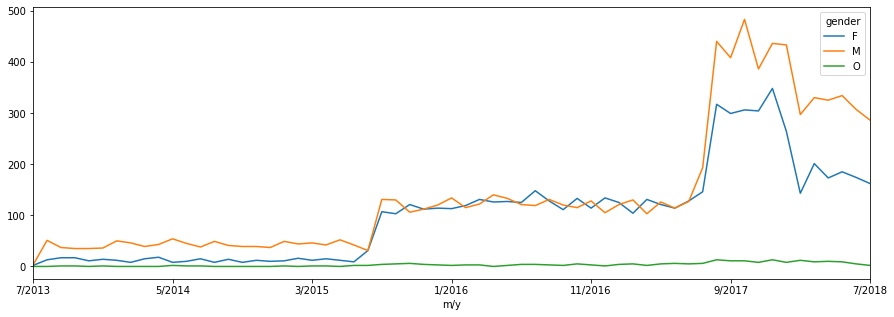

In [39]:
monthly_new_users_bysex = profile.groupby(['year_bmo', 'month_bmo', 'gender'])['age'].count().reset_index()
monthly_new_users_bysex.rename({'age':'new_users_count'}, axis = 1, inplace = True)
monthly_new_users_bysex['m/y'] = monthly_new_users_bysex['month_bmo'].apply(lambda x: str(x)) + '/' + monthly_new_users_bysex['year_bmo'].apply(lambda x: str(x))
monthly_new_users_bysex.set_index('m/y', inplace = True)
monthly_new_users_bysex = monthly_new_users_bysex.pivot(columns = 'gender')
monthly_new_users_bysex.sort_values([('year_bmo', 'M'), ('month_bmo', 'M')])['new_users_count'].fillna(0).plot()

We can see that, appart from a period lasting from mid-2015 to mid-2017, consistently there were more males registering as new customers than females.

We can also see that the people we don't have any information of is negligible, specially from mid-2015 on.

Now, for the rest of our exploration, we will rely on our clean_profile dataframe, as in the original, there was a lot of information missing.

<br>

<img src='images/demography.png' width=400>

<br>

Let's take a look on our profiles, and examine the economic characteristics of our customer base:

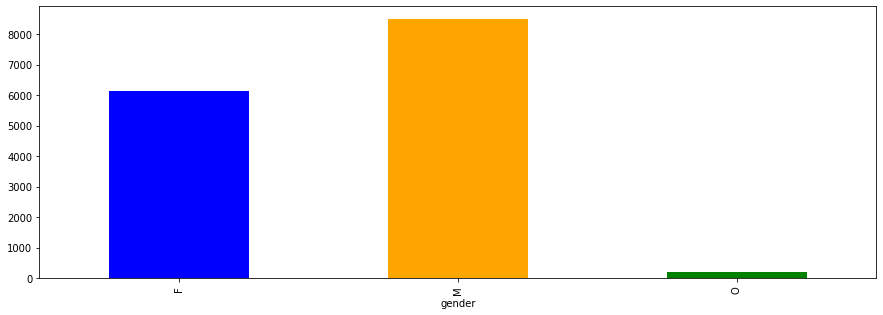

In [40]:
clean_profile.groupby('gender')['id'].count().plot(kind = 'bar', color=['b', 'orange', 'g'])

We can see that, as we expected, there are more men than women registered as client.

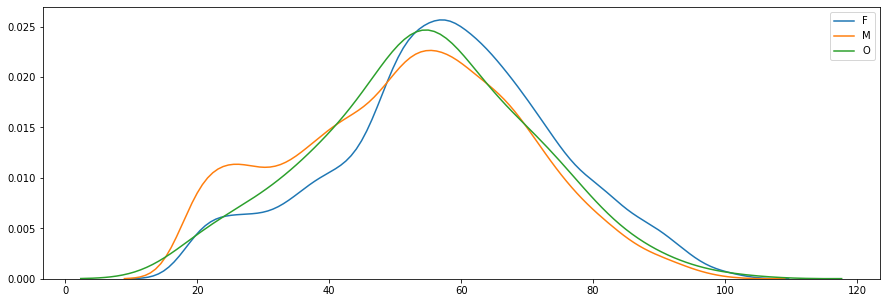

In [41]:
for value in clean_profile['gender'].unique():
    sns.kdeplot(clean_profile[clean_profile['gender'] == value]['age'], label = value)

The age distributions of our three genders in our dataset peak at around 60 years.

Between the men, we can see a plateau around the age of 20, that will probably pull down their average age.

Let's check our clients average ages:

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64


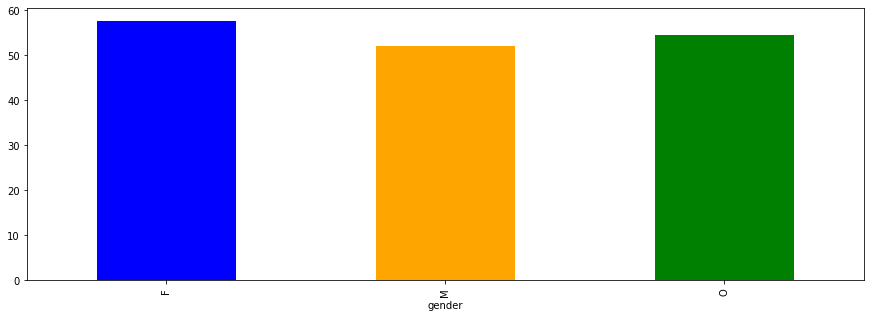

In [42]:
age_per_gender_means = clean_profile.groupby('gender')['age'].mean()
print(age_per_gender_means)
age_per_gender_means.plot(kind='bar',  color=['b', 'orange', 'g'])

As we suspected, average age of our consumers is just beneath 60 years old, and also we can see that the mean age value of men is slightly less than that of the other two groups.

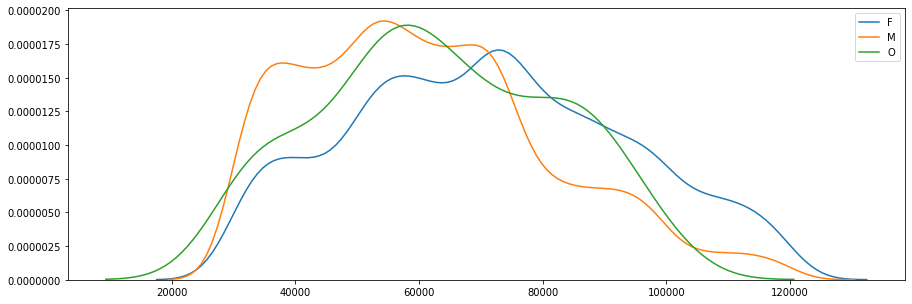

In [43]:
for value in clean_profile['gender'].unique():
    sns.kdeplot(clean_profile[clean_profile['gender'] == value]['income'], label = value)

We can see that, from our clients, females earn the most, the other, and then, the males.

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64


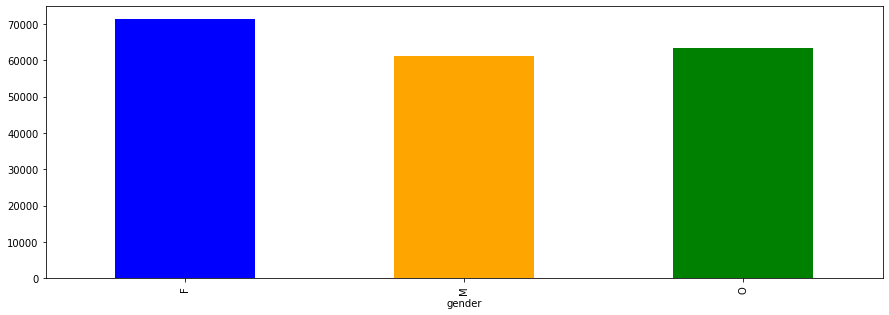

In [44]:
income_per_gender_means = clean_profile.groupby('gender')['income'].mean()
print(income_per_gender_means)
income_per_gender_means.plot(kind='bar',  color=['b', 'orange', 'g'])

Finally, let's check the distribution of incomes per age:

Text(0.5, 1.0, 'Income distribution by age')

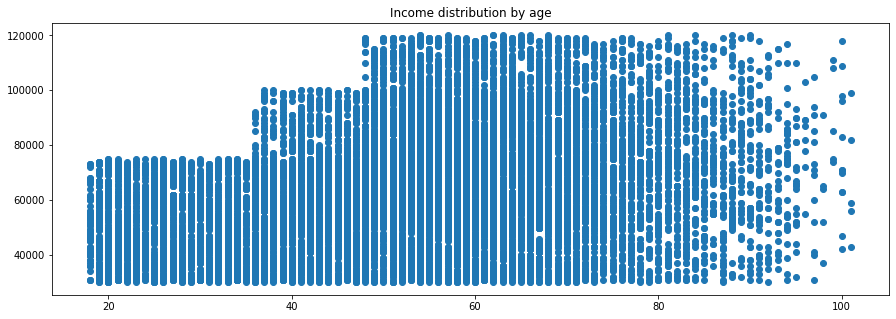

In [45]:
plt.scatter(clean_profile['age'], clean_profile['income'], label = value)
plt.title('Income distribution by age')

Aha! Seems very clear that some kind of random algorithm was used to randomly assign incomes in the dataset, and that for different age groups, a different upper limit was stablished.

...adding the sex to the equation:

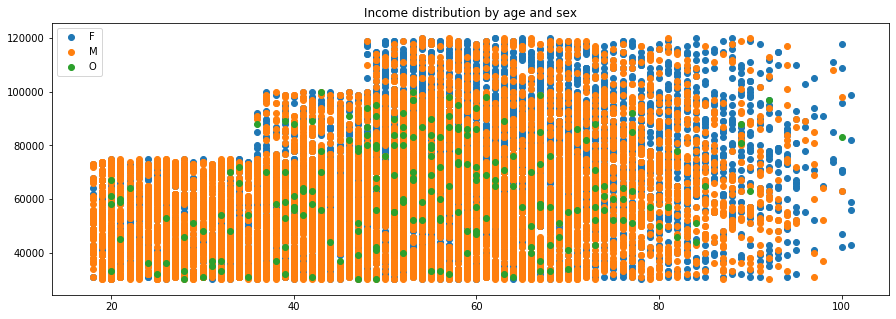

In [46]:
for value in clean_profile['gender'].unique():
    plt.scatter(clean_profile[clean_profile['gender'] == value]['age'],
                clean_profile[clean_profile['gender'] == value]['income'],
                label = value)
    plt.legend()
    plt.title('Income distribution by age and sex')

...doesn't seem to change our results... but it seems clear that, as a result of this, a relationship exists between age and income.

In [47]:
max_inc_per_age = clean_profile.groupby('age')['income'].max()
max_inc_per_age[max_inc_per_age.diff()>5000]

age
36      92000.0
37     100000.0
48     119000.0
99     111000.0
100    118000.0
Name: income, dtype: float64

In [48]:
clean_profile.groupby('age')['income'].min().unique()

array([31000., 30000., 36000., 32000., 35000., 55000., 37000., 74000.,
       42000., 43000.])

We will create different categories based in this discovery:

In [49]:
clean_profile['age_group'] = clean_profile['age'].apply(lambda x: 'young' if x<36 else ('prime' if x<48 else 'wise'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now, we can take a look at the different income distributions of the different groups:

In [50]:
clean_profile.groupby('age_group')['income'].mean()

age_group
prime    58883.759275
wise     70431.122195
young    50844.566133
Name: income, dtype: float64

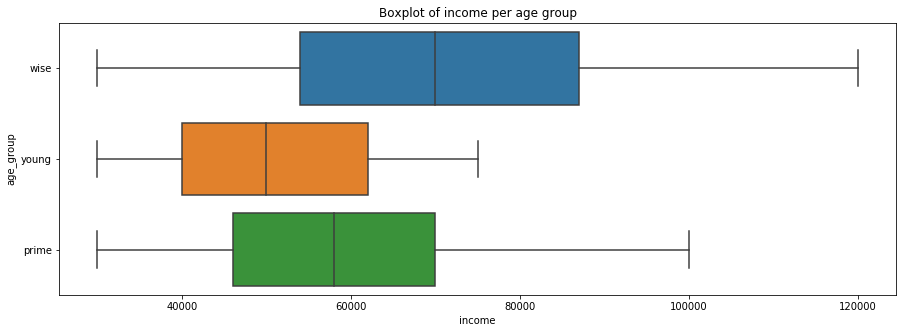

In [51]:
a = sns.boxplot(clean_profile['income'], clean_profile['age_group'], orient = 'h')
plt.title('Boxplot of income per age group');

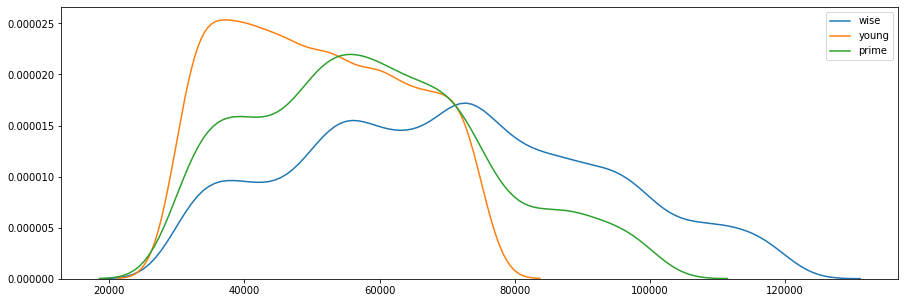

In [52]:
for value in clean_profile['age_group'].unique():
    sns.kdeplot(clean_profile[clean_profile['age_group'] == value]['income'], label = value)

Now, let's check transactions: 


<img src='images/transactions.png' width = 200 align='left'>

Let's see how much information we have per user:

In [53]:
total_offers_per_user = transcript.groupby(['id'])['value'].count().sort_values(ascending = False)
total_offers_per_user.head(10)

id
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
a42ed50acc4d4b25bca647c9e0b916ad    46
b1f4ece7d49342628a9ed77aee2cde58    46
28681c16026943e68f26feaccab0907f    46
bd2cdd691aca4bb0a0e039979ee5de5c    46
ab25fd6fbd5040f880751921e4029757    44
Name: value, dtype: int64

Let's see the distribution:

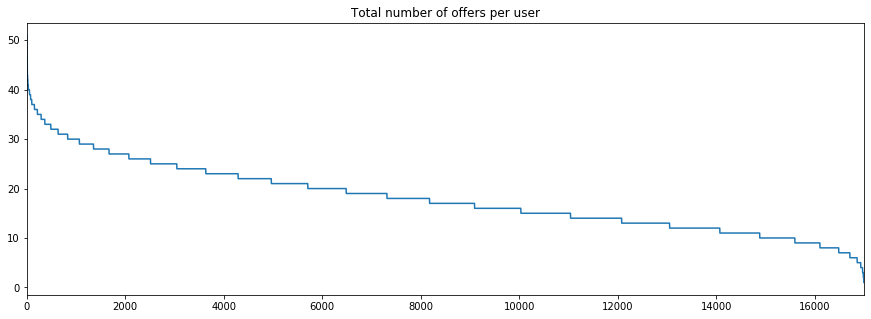

In [54]:
total_offers_per_user.plot(figsize = (15,5), use_index = False, title = 'Total number of offers per user');

Let's check a couple of examples:

In [55]:
transcript2[transcript2['id'] == total_offers_per_user.index[0]].sort_values('time').head(10)

,event,id,time,amount,offer_id,reward,event_num
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,7.41,NaN,NaN,-1
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0.0,2
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,1.47,NaN,NaN,-1
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,2.62,NaN,NaN,-1
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,0.59,NaN,NaN,-1
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,2.28,NaN,NaN,-1


As we already knew, we have offers and transactions mixed.

It will be better to separate both concepts in separate tables, for a nicer handling.

We well check the information on the least represented customers:

In [56]:
transcript2[transcript2['id'].isin(total_offers_per_user[total_offers_per_user <= 2].index)].sort_values(['id', 'time'])

,event,id,time,amount,offer_id,reward,event_num
116832,offer received,1bfe13d2453c4185a6486c6817e0d568,336,NaN,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0
144455,offer viewed,1bfe13d2453c4185a6486c6817e0d568,384,NaN,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1
201981,offer received,22617705eec442e0b7b43e5c5f56fb17,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0
214403,offer viewed,22617705eec442e0b7b43e5c5f56fb17,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1
253904,offer received,3045af4e98794a04a5542d3eac939b1f,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
260855,offer viewed,3045af4e98794a04a5542d3eac939b1f,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1
112524,offer received,3a4e53046c544134bb1e7782248631d1,336,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
203287,offer received,3a4e53046c544134bb1e7782248631d1,504,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
249251,offer received,912b9f623b9e4b4eb99b6dc919f09a93,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
269722,offer viewed,912b9f623b9e4b4eb99b6dc919f09a93,594,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1


In this case, we can see that, from the tail of the distributions, there are a lot of offers but just one transaction.

We are now segregating the our transcript dataframe into transactions and offers: 

In [57]:
transactions = transcript2[~transcript2['amount'].isna()]
transactions.drop(['offer_id', 'reward'], axis = 1, inplace = True)
transactions.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,id,time,amount,event_num
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,-1
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,-1
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,-1
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,-1
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,-1


In [58]:
offers = transcript2[~transcript2['offer_id'].isna()]
offers.drop('amount', axis = 1, inplace = True)
offers.head()

,event,id,time,offer_id,reward,event_num
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


So, now, let's go back to extracting insights.

First, we will group to see the total amount spent by each user, it maximum, mean, and the distribution of amounts of the top 100 spenders:

In [59]:
spend_per_user = transactions.groupby('id')['amount'].sum().reset_index().sort_values('amount', ascending = False)
print(spend_per_user['amount'].max())
print(spend_per_user['amount'].mean())
spend_per_user.head(10)

1608.69
107.0968735673784


,id,amount
3929,3c8d541112a74af99e88abbd0692f00e,1608.69
15693,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
11422,ae6f43089b674728a50b8727252d3305,1327.74
6366,626df8678e2a4953b9098246418c9cfa,1321.42
7492,73afdeca19e349b98f09e928644610f8,1319.97
5358,52959f19113e4241a8cb3bef486c6412,1292.86
11334,ad1f0a409ae642bc9a43f31f56c130fc,1258.19
13672,d240308de0ee4cf8bb6072816268582b,1251.99
9673,946fc0d3ecc4492aa4cc06cf6b1492c3,1232.40
6484,6406abad8e2c4b8584e4f68003de148d,1211.76


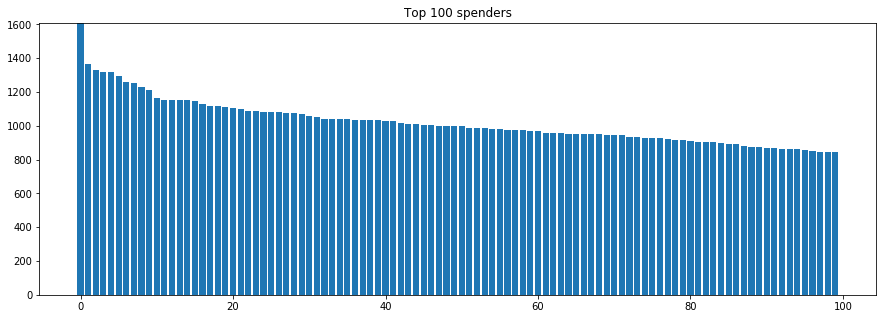

In [60]:
plt.bar(range(0,100), spend_per_user[:100]['amount'])
plt.ylim(ymax = spend_per_user['amount'].max(), ymin = 0)
plt.title('Top 100 spenders');

Now, let's do the analogous with the offers received by each user (without the informational emails):

In [61]:
# offers include all the evolution of every offer. So we are interested in the offers sent:
offers_per_user = offers[offers['event_num']==0].groupby('id')['offer_id'].count().reset_index().sort_values('offer_id', ascending = False)
offers_per_user.head(10)

,id,offer_id
16927,ffff82501cea40309d5fdd7edcca4a07,6
8837,8582150967d2440e93a857b4ef460f43,6
11661,aea4564b32c5480cbdf1c5813d2aa279,6
2106,211c1fdfe7e047e3b88cf267824ca6df,6
13964,d24693b4f6d141538c41138995cf1ade,6
5663,5572f20d70d84447b09413776106aea1,6
8866,86044a1798d646e18b43cd813f7a79c5,6
15686,ecd437c130854cb9abb2672f35e76f26,6
3709,38999f1dd0d44dc2b2f8278d2409681a,6
3710,389bc3fa690240e798340f5a15918d5c,6


In [62]:
print(offers_per_user['offer_id'].max())
print(offers_per_user['offer_id'].mean())

6
3.6059782608695654


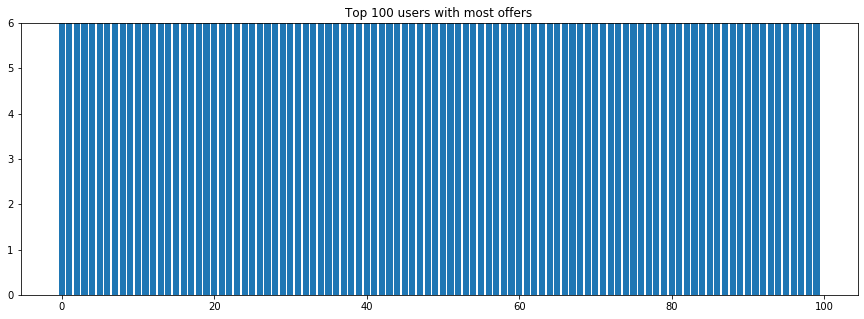

In [63]:
plt.bar(range(0,100), offers_per_user[:100]['offer_id'])
plt.ylim(ymax = offers_per_user['offer_id'].max(), ymin = 0)
plt.title('Top 100 users with most offers');

Now, we are going to calculate the successful offers per user:

In [64]:
# Successful offers per user:
succ_offers_per_user = offers[offers['event_num']==2].groupby('id')['offer_id'].count().reset_index().sort_values('offer_id', ascending = False)

Let's merge those tables and get new insights:

In [65]:
aux1 = pd.merge(offers_per_user, spend_per_user, on=['id'], how='left').fillna(0)
totals_per_user = pd.merge(aux1, succ_offers_per_user, on=['id'], how='left').fillna(0)
totals_per_user.rename({'offer_id_x':'tot_offers_received', 'offer_id_y':'tot_offers_succesful'}, axis = 1, inplace = True)
totals_per_user['offer_success_ratio'] = totals_per_user['tot_offers_succesful']/ totals_per_user['tot_offers_received']

Now, we proceed to study the existing relationships in our offers:

<br>

<img src='images/economics.jpeg' width=500>

<br>


Let's see whether there is a relationship between the number of offers received and the mean amount spent by each user:

,tot_offers_received,mean_amount
0,1,84.240872
1,2,87.368896
2,3,99.383500
3,4,109.292645
4,5,118.215565
5,6,119.412113


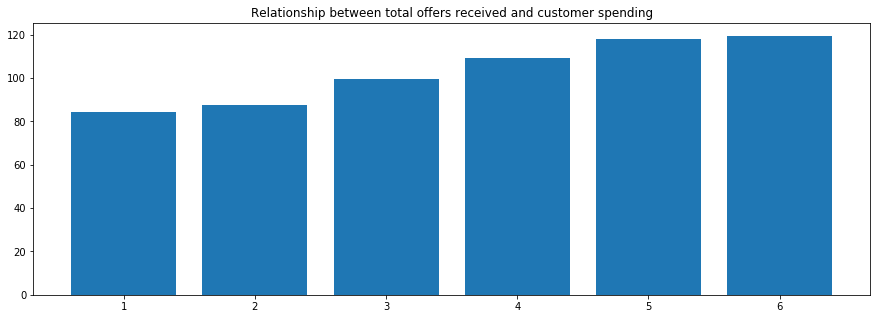

In [66]:
offers_amount = totals_per_user.groupby(['tot_offers_received'])['amount'].mean().reset_index().rename({'amount':'mean_amount'}, axis=1)
plt.bar(offers_amount['tot_offers_received'], offers_amount['mean_amount'])
plt.title('Relationship between total offers received and customer spending')
offers_amount

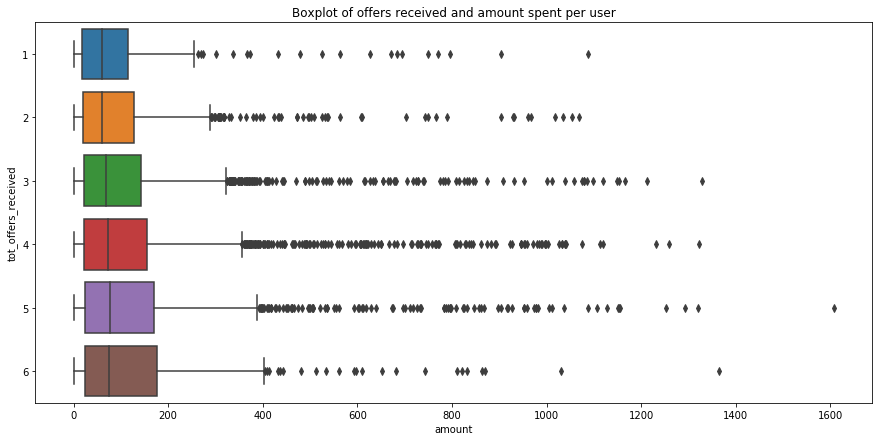

In [67]:
fig_boxplot = plt.figure(figsize=[15,7])
a = sns.boxplot(totals_per_user['amount'], totals_per_user['tot_offers_received'], orient = 'h')
plt.title('Boxplot of offers received and amount spent per user');

Now, let's see if sending more or less offers to the user has an inpact on the offer success ratio:

,tot_offers_received,mean_offer_success_ratio
0,1,0.514019
1,2,0.545111
2,3,0.551466
3,4,0.554793
4,5,0.547867
5,6,0.542680


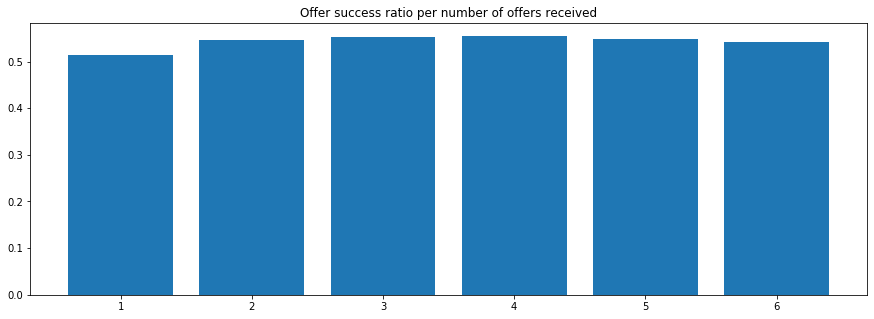

In [68]:
offer_success_ratio = (totals_per_user.groupby(['tot_offers_received'])['offer_success_ratio']
                                       .mean()
                                       .reset_index()
                                       .rename({'offer_success_ratio':'mean_offer_success_ratio'}, axis=1)
                      )

plt.bar(offer_success_ratio['tot_offers_received'], offer_success_ratio['mean_offer_success_ratio'])
plt.title('Offer success ratio per number of offers received')
offer_success_ratio

It seems that the number of offers sent has no impact on the success ratio of the offers.

Finally, we will check if there is a relationship between the success ratio of the offers sent to a client and their spending:

,offer_success_ratio,mean_amount
0,0.000000,17.346861
1,0.166667,29.082619
2,0.200000,31.352850
3,0.250000,34.187032
4,0.333333,46.039110
5,0.400000,54.585753
6,0.500000,72.351770
7,0.600000,95.042754
8,0.666667,103.598478
9,0.750000,134.182789


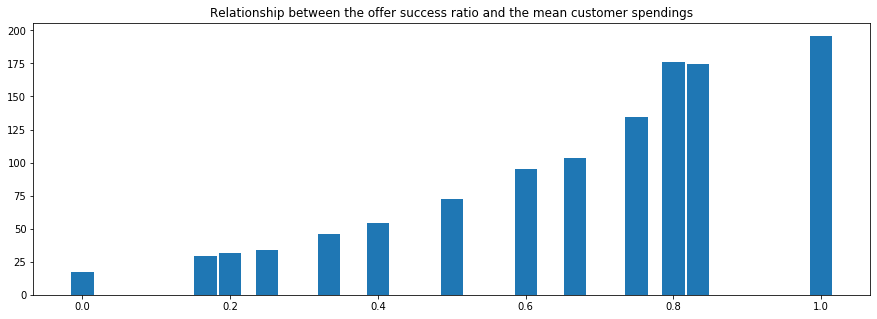

In [69]:
success_ratio_amount = totals_per_user.groupby(['offer_success_ratio'])['amount'].mean().reset_index().rename({'amount':'mean_amount'}, axis=1)
plt.bar(success_ratio_amount['offer_success_ratio'], success_ratio_amount['mean_amount'], width = 0.03)
plt.title('Relationship between the offer success ratio and the mean customer spendings')
success_ratio_amount

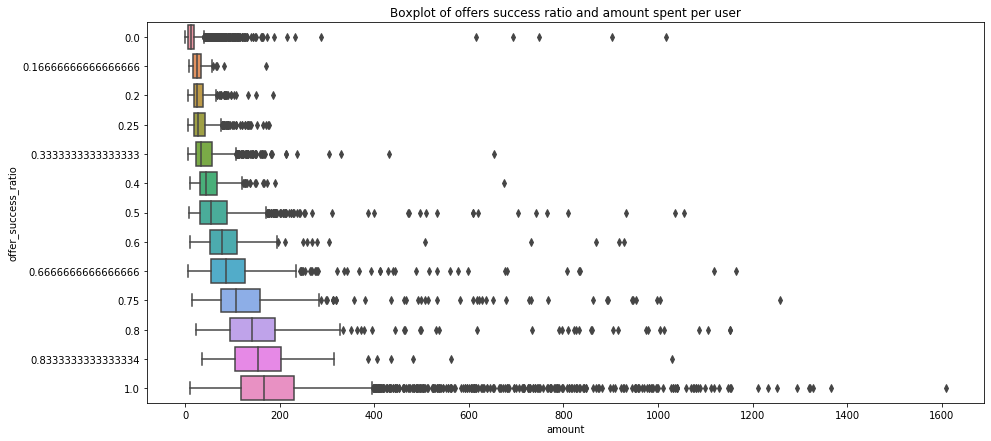

In [70]:
fig_boxplot = plt.figure(figsize=[15,7])
a = sns.boxplot(totals_per_user['amount'], totals_per_user['offer_success_ratio'], orient = 'h')
plt.title('Boxplot of offers success ratio and amount spent per user');

We can also see here a strong positive correlation between the offer success ratio and the mean amount spent.

These conclussions can be sumarized by studying the correlations among the variables of this table:

,tot_offers_received,amount,tot_offers_succesful,offer_success_ratio
tot_offers_received,1.000000,0.084203,0.405815,0.007721
amount,0.084203,1.000000,0.573025,0.578805
tot_offers_succesful,0.405815,0.573025,1.000000,0.864550
offer_success_ratio,0.007721,0.578805,0.864550,1.000000


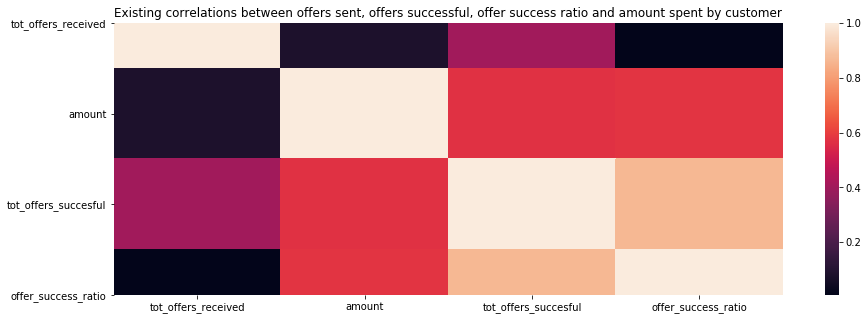

In [71]:
correlations = totals_per_user.corr()
sns.heatmap(correlations)
plt.title('Existing correlations between offers sent, offers successful, offer success ratio and amount spent by customer')
correlations

**Merging the information:**

This is useful information, so we will anex it to our clean_profile dataframe:

In [72]:
clean_profile_expanded = pd.merge(clean_profile, totals_per_user, on='id', how='left')

**Sex and age and success ratio:**

Now, we can see, for instance, that our success ratio depends on the gender:

gender
F    0.704036
M    0.536959
O    0.687283
Name: offer_success_ratio, dtype: float64

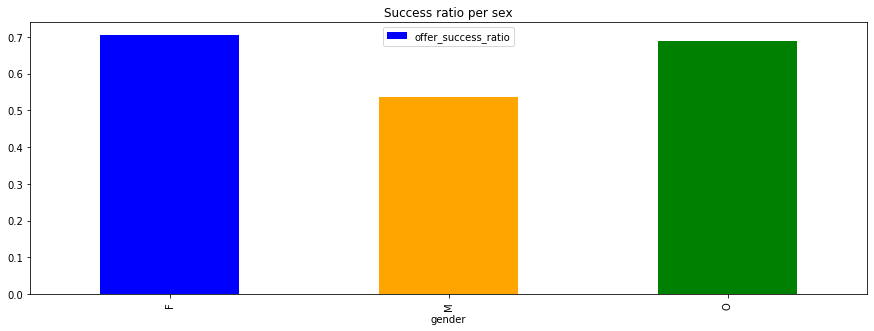

In [73]:
success_ratio_per_genre = clean_profile_expanded.groupby('gender')['offer_success_ratio'].mean()
success_ratio_per_genre.plot('bar', color=['b', 'orange', 'g'], legend = True, title = 'Success ratio per sex')
success_ratio_per_genre

age_group
prime    0.577248
wise     0.644902
young    0.484497
Name: offer_success_ratio, dtype: float64

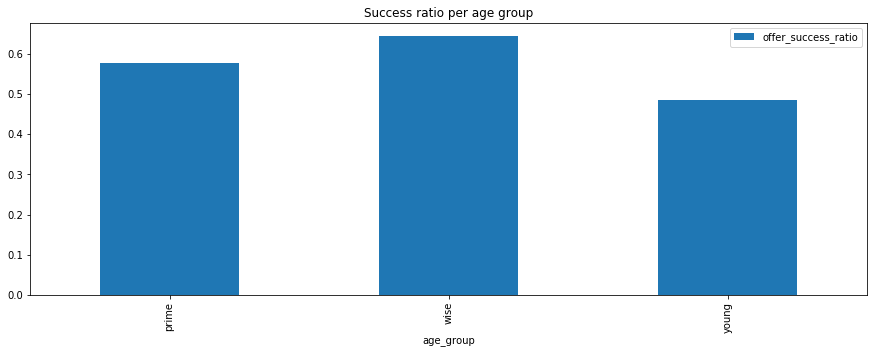

In [74]:
success_ratio_per_age_group = clean_profile_expanded.groupby('age_group')['offer_success_ratio'].mean()
success_ratio_per_age_group.plot('bar', legend = True, title = 'Success ratio per age group')
success_ratio_per_age_group

Also, there are several customers with no info on regarding transactions:

In [75]:
clean_profile_expanded[clean_profile_expanded['amount'].isna()].shape[0]

61

In [76]:
customer_wo_info = list(clean_profile_expanded[clean_profile_expanded['amount'].isna()]['id'])

In [77]:
print(transcript2[transcript2['id'].isin(customer_wo_info)].shape)
transcript2[transcript2['id'].isin(customer_wo_info)].head()

(331, 7)


,event,id,time,amount,offer_id,reward,event_num
13747,transaction,43ffb6ce475d4ccba9828e4a07a4c31f,0,18.60,NaN,NaN,-1
16224,transaction,4eb999a6a45a4f3896e250e531ae90fb,6,8.74,NaN,NaN,-1
16379,transaction,eb540099db834cf59001f83a4561aef3,6,4.74,NaN,NaN,-1
17466,transaction,cb8291d29fcd482b8793aa18c970a71b,6,2.17,NaN,NaN,-1
21242,transaction,ab36b436924042459401a8e140795a7e,18,8.93,NaN,NaN,-1


We see that those customers spent some money, and perhaps they did receive some informational offers, but didn't receive any discounts. Let's fix this in our table:

In [78]:
transcript_missing_custs = transcript2[transcript2['id'].isin(customer_wo_info)]
missing_custs_dict = dict(transcript_missing_custs.groupby('id')['amount'].sum())

missing_index = clean_profile_expanded[clean_profile_expanded['amount'].isna()].index
clean_profile_expanded.loc[missing_index,'amount'] = clean_profile_expanded['id'].apply(lambda x: missing_custs_dict[x] if x in missing_custs_dict.keys() else 0)

clean_profile_expanded.loc[missing_index,'amount'].head()

155    155.64
683     26.49
745      6.95
770     83.34
956     42.63
Name: amount, dtype: float64

Finally, we now replace the offer values of those lines with zeroes:

In [79]:
clean_profile_expanded.fillna(0, inplace = True)

Now, as we remember from earlier exploration, not all users from our clean_profile table did match our transcript tables, as we dropped some users without information on some vital regards.

As we have abundant data, let's filter it by those customers from whom we have all the information:

In [80]:
clean_transcript = transcript2[transcript2['id'].isin(clean_profile_expanded['id'])]
clean_transactions = transactions[transactions['id'].isin(clean_profile_expanded['id'])]
clean_offers = offers[offers['id'].isin(clean_profile_expanded['id'])]

print(len(clean_transcript))
print(len(clean_transactions))
print(len(clean_offers))
print(len(clean_transactions) + len(clean_offers))

250102
123957
126145
250102


In [81]:
print(len(clean_transcript['id'].unique()))
print(len(clean_transactions['id'].unique()))
print(len(clean_offers['id'].unique()))

14822
14492
14764


Those sanity checks confirm all is OK. 

If using clean_transactions and clean_offers, we have to keep in mind that not all clients received offers, neither all of them performed transactions.

## 4) Merging and feature engineering

After examining our data and having provided our first insights, we are now ready to do some feature engineering.

In order to do so, we will now proceed to merge the clean_offers and clean_transactions dataframes, and we will include the insight we will extract to the clean_profile_expanded.



### 4.1) Offers division

<br>

We currently face a big problem that we need to assess before continuing:

<br>

<img src="images/cards.jpg" width = 500/>


<br>



In [82]:
clean_offers.groupby(['id', 'offer_id'])['event_num'].count().reset_index().sort_values('event_num', ascending = False).head()

,id,offer_id,event_num
7666,2dab8c385a2440b78b432ecb72d68787,2298d6c36e964ae4a3e7e9706d1fb8c2,12
16889,61f661b7070c4063880a85b22f1fe0e4,2906b810c7d4411798c6938adc9daaa5,12
6625,281d463f31e74ecaa4451d169868c5d7,2298d6c36e964ae4a3e7e9706d1fb8c2,12
18866,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,12
36528,d3209835a40a423fbf2c967218d00bcd,ae264e3637204a6fb9bb56bc8210ddfd,12


As we see, there is not a unique combination of id and offer_id in the tables (as we also saw above), as the same offer has been sent to the same customer several times, in different moments of time.

Also, the same exact offer has multiple values, as it is shown its evolution, from received to completed, going through viewed:

In [83]:
clean_offers[(clean_offers['id'] == 'd3209835a40a423fbf2c967218d00bcd')&
             (clean_offers['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd')]

,event,id,time,offer_id,reward,event_num
4301,offer received,d3209835a40a423fbf2c967218d00bcd,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0
26706,offer viewed,d3209835a40a423fbf2c967218d00bcd,36,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1
35998,offer completed,d3209835a40a423fbf2c967218d00bcd,72,ae264e3637204a6fb9bb56bc8210ddfd,0.0,2
57537,offer received,d3209835a40a423fbf2c967218d00bcd,168,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0
84070,offer viewed,d3209835a40a423fbf2c967218d00bcd,210,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1
92637,offer completed,d3209835a40a423fbf2c967218d00bcd,240,ae264e3637204a6fb9bb56bc8210ddfd,0.0,2
205881,offer received,d3209835a40a423fbf2c967218d00bcd,504,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0
219621,offer viewed,d3209835a40a423fbf2c967218d00bcd,510,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1
249451,offer received,d3209835a40a423fbf2c967218d00bcd,576,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0
275441,offer viewed,d3209835a40a423fbf2c967218d00bcd,606,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1


**TWO DECISIONS:**



We decide to further **divide this dataset in two: the received offers and the completed offers.**
    
We also decide to **drop the viewed offers in the process**, as we are not interested in the information they might give us (at least, for now):

In [84]:
vals = ['time', 'id','offer_id']
clean_offers_rec = clean_offers[clean_offers['event_num'] == 0].sort_values(vals)[['id', 'offer_id', 'time']]
clean_offers_completed = clean_offers[clean_offers['event_num'] == 2].sort_values(vals)[['id', 'offer_id', 'time', 'event_num']]

### 4.2) Automerging

Before merging both datasets, we need to uniquely identify each offer.

We do so by joining the customer and offer id fields, and adding a counter (starting in 0 for the earliest offer sent) for each time the same offer is presented to the same customer.

We do it so for both dataframes.

The idea in my head is that we are performing a "shuffle":

<br>

<img src="images/shuffle.jpg" width = 500/>

<br>

Then, we will merge the two dataframes using that columns created.

**In doing so, we assume that, when in conflict, the offer redeem is the first sent, which is logical (and the best we can do, with the available information), but not necesarily true.**

That shouldn't be much of a problem:



In [85]:
# Creating the columns and making some ammendments to both datasets:

for df in [clean_offers_rec, clean_offers_completed]:
    df['cust_offer_id'] = df['id'] + '_' + df['offer_id'].apply(lambda x: x[-5:])
    df['aux'] = df.groupby(['cust_offer_id']).cumcount()
    df['aux'] = df['aux'].apply(lambda x: str(x))
    df['cust_offer_id'] = df['cust_offer_id'] +"_" + df['aux']
    df.drop('aux', axis = 1, inplace = True)

In [86]:
clean_offers_completed.columns

Index(['id', 'offer_id', 'time', 'event_num', 'cust_offer_id'], dtype='object')

In [87]:
# Joining them to create matched_offers:

matched_offers = pd.merge(clean_offers_rec, 
                          clean_offers_completed[['cust_offer_id', 'time', 'event_num']], 
                          on=['cust_offer_id'], 
                          how='left')

Now, a small sanity check:

In [88]:
# We are checking that there are no duplicated records to the left, as a result of the merge:
assert clean_offers_rec.shape[0] == matched_offers[matched_offers['event_num'].isna()].shape[0] + clean_offers_completed.shape[0]

In [89]:
# Now, we rename the columns present in both dataframes before the merge, so it is clearly stated what they represent:
matched_offers.rename({'time_x':'time_sent', 'time_y':'time_comp'},
                      axis = 1,
                      inplace = True)

Now, we can easily calculate how long took to each fullfilled offer to get to that state. We can then perform another sanity check: no time should be negative:

In [90]:
matched_offers['time_diff'] = matched_offers['time_comp'] - matched_offers['time_sent']
len(matched_offers[matched_offers['time_diff']<0])

0

We display now the maximum values for the calculated times, and present the records associated to those times:

In [91]:
max_vals = matched_offers['time_diff'].sort_values(ascending = False).unique()[:5]
print(max_vals)
matched_offers[matched_offers['time_diff'].isin(max_vals)].head()

[714. 708. 696. 690. 684.]


,id,offer_id,time_sent,cust_offer_id,time_comp,event_num,time_diff
533,0ff34474e5b245b79f396d4c5ddef96c,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0ff34474e5b245b79f396d4c5ddef96c_fb8c2_0,708.0,2.0,708.0
1121,231e1e33467647bbba31f6ba36d88541,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,231e1e33467647bbba31f6ba36d88541_2e1d7_0,708.0,2.0,708.0
1693,329b390a8e19481ab081d99e4e813835,fafdcd668e3743c1bb461111dcafc2a4,0,329b390a8e19481ab081d99e4e813835_fc2a4_0,690.0,2.0,690.0
2461,46c68b0d9eb74bff8666bdb2f86a620d,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,46c68b0d9eb74bff8666bdb2f86a620d_2e1d7_0,690.0,2.0,690.0
2815,512191a2ec58463fafd3fd544bf7bed6,2298d6c36e964ae4a3e7e9706d1fb8c2,0,512191a2ec58463fafd3fd544bf7bed6_fb8c2_0,708.0,2.0,708.0


Finally, we will fill the missing values resulting from our merge, with coherent values:
    
* reward should be set to 0, as the offer has not been redeemed.

* event_c, as reward, should be set to 0, as it is the corresponding status of a received offer (we will prescind from this point of the "viewed" status).

In [92]:
dict_to_fill = {'event_num':0}

for key in dict_to_fill.keys():
    matched_offers[key].fillna(dict_to_fill[key], inplace = True)
    
# We now perform again the "time_diff" calculation, so "time_diff" values incorporate the new arranges in "time_comp"
    
matched_offers['time_diff'] = matched_offers['time_comp'] - matched_offers['time_sent']

### 4.3) New features for our profile dataframe

<img src="images/Features.jpeg" width = 400/>

Now, we are going to include this information within the clean_profile_expanded dataframe.

We will do it so, by passing the mean, max and min waiting time values per user, for all offers for that user:

In [93]:
reply_times_per_user = matched_offers.groupby('id')['time_diff'].agg(['mean', 'max', 'min']).reset_index()

renaming_cols_dict = dict(zip(['mean', 'max', 'min'], ['mean_resp_t', 'max_resp_t', 'min_resp_t']))

reply_times_per_user.rename(renaming_cols_dict, axis = 1, inplace = True)

Now, many of our users have never replied to an offer, plus some even haven't receive one (obviating the informationals).

Let's see how many of our customers we don't any have information on this regard:

In [94]:
clean_profile_expanded = pd.merge(clean_profile_expanded, reply_times_per_user, on='id', how='left')

In [95]:
# Checking how many users don't have ever used an offer:
print(clean_profile_expanded[clean_profile_expanded['mean_resp_t'].isna()]['id'].count())
clean_profile_expanded[clean_profile_expanded['mean_resp_t'].isna()].head()

2839


,age,gender,id,income,date_bmo,year_bmo,month_bmo,day_bmo,seniority,age_group,tot_offers_received,amount,tot_offers_succesful,offer_success_ratio,mean_resp_t,max_resp_t,min_resp_t
10,61,F,a448667f336b42c9a66fc5ffd5d73772,40000.0,2018-05-01,2018,5,1,86,wise,2.0,20.78,0.0,0.0,NaN,NaN,NaN
17,46,F,7429a044884842d6862f516c38b1156f,59000.0,2017-09-11,2017,9,11,318,prime,3.0,2.88,0.0,0.0,NaN,NaN,NaN
28,20,F,02c083884c7d45b39cc68e1314fec56c,30000.0,2016-07-11,2016,7,11,745,young,2.0,29.89,0.0,0.0,NaN,NaN,NaN
41,45,M,186d6403f5824c739555b732f4af3f16,48000.0,2017-10-06,2017,10,6,293,prime,3.0,17.00,0.0,0.0,NaN,NaN,NaN
50,77,M,d8af520c4a8a4c77b921098d7d838c4d,51000.0,2016-07-30,2016,7,30,726,wise,3.0,23.81,0.0,0.0,NaN,NaN,NaN


### 4.4) Merging offers with transactions

Now, it is the clean_transactions turn:

We will merge this table to the matched_offers, to obtain the transactional value of each redeemed offer:

In [96]:
# We assume for the following procedures that the combination id-time of a purchase is unique.
# Here we verify it before continuing:

unique_id_times = set(clean_transactions['id'] + clean_transactions['time'].astype('str'))

assert len(clean_transactions) == len(unique_id_times)

In [97]:
expanded_matched_offers = pd.merge(matched_offers,
                                   clean_transactions[['id', 'time', 'amount']],
                                   left_on = ['id', 'time_comp'],
                                   right_on = ['id', 'time'],
                                   how = 'left')

expanded_matched_offers.drop('time', axis = 1, inplace = True)

expanded_matched_offers['amount'].fillna(0, inplace = True)

assert expanded_matched_offers.shape[0] == matched_offers.shape[0]

expanded_matched_offers.head()

,id,offer_id,time_sent,cust_offer_id,time_comp,event_num,time_diff,amount
0,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,0020c2b971eb4e9188eac86d93036a77_fc2a4_0,54.0,2.0,54.0,17.63
1,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,0,005500a7188546ff8a767329a2f7c76a_0ddfd_0,NaN,0.0,NaN,0.00
2,0056df74b63b4298809f0b375a304cf4,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0056df74b63b4298809f0b375a304cf4_9e6d9_0,132.0,2.0,132.0,27.86
3,00715b6e55c3431cb56ff7307eb19675,ae264e3637204a6fb9bb56bc8210ddfd,0,00715b6e55c3431cb56ff7307eb19675_0ddfd_0,12.0,2.0,12.0,27.26
4,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,0,00840a2ca5d2408e982d56544dc14ffd_daaa5_0,540.0,2.0,540.0,6.05


Appart from that, we can also try to determine how long ago had been the last purchase performed before sending the offer:

In [98]:
prov = pd.merge(matched_offers,
                clean_transactions[['id', 'time', 'amount']],
                on=['id'],
                how = 'left')

# Filtering the dataframe to keep only those purchases that occured previously to an offer, calculating the time difference
# and selecting the minimums of those differences:

prov = prov[(prov['time'] >= prov['time_sent'])]
prov['t_fr_lst_pur'] =prov['time'] - prov['time_sent']

agg_dict = {'t_fr_lst_pur':'min', 'amount':'mean'}
last_purchase_times = prov.groupby('cust_offer_id').agg(agg_dict).reset_index()
last_purchase_times.rename({'amount':'mean_am'}, axis=1, inplace=True)

In [99]:
expanded_matched_offers = expanded_matched_offers.merge(last_purchase_times, on=['cust_offer_id'], how='left')

It is possible that many offers have been sent to customers that had still not bought anything. Let's check how many of these cases there are:

In [100]:
len(expanded_matched_offers[expanded_matched_offers['t_fr_lst_pur'].isna()])

3383

Before modelling, we will have to decide what to do with these values.

In [101]:
automerged_cln_trans = clean_transactions.merge(clean_transactions, on='id')

automerged_cln_trans = automerged_cln_trans[automerged_cln_trans['time_x']>automerged_cln_trans['time_y']]

automerged_cln_trans['pur_interval'] = automerged_cln_trans['time_x'] - automerged_cln_trans['time_y']

interval_btw_purchs = automerged_cln_trans.groupby(['id', 'time_x'])['pur_interval'].min().reset_index()

interval_btw_purchs.rename({'time_x':'time'}, axis=1, inplace=True)

interval_btw_purchs.head()

,id,time,pur_interval
0,0009655768c64bdeb2e877511632db8f,414,186
1,0009655768c64bdeb2e877511632db8f,528,114
2,0009655768c64bdeb2e877511632db8f,552,24
3,0009655768c64bdeb2e877511632db8f,576,24
4,0009655768c64bdeb2e877511632db8f,660,84


In [102]:
clean_transactions = clean_transactions.merge(interval_btw_purchs, on=['id', 'time'], how='left')

### 4.5) More features for our profile dataframe

<img src="images/feature_factory.png" width = 400/>

With that information, aggregating by user we can determine how much each user spent in all our offers, and by merging, we include that information also in our profile dataframe:

In [103]:
clean_profile_expanded = pd.merge(clean_profile_expanded, 
                                  clean_transactions.groupby('id')['amount'].count().reset_index().rename({'amount':'nbr_pur'}, axis=1), 
                                  on='id', 
                                  how='left')

clean_profile_expanded[clean_profile_expanded['nbr_pur'].isna()].shape[0]

333

In [104]:
clean_profile_expanded = pd.merge(clean_profile_expanded,
                                  expanded_matched_offers.groupby('id')['amount'].sum().reset_index(),
                                  on = ['id'],
                                  how = 'left')

clean_profile_expanded.rename({'amount_x':'tot_am_spent', 'amount_y':'tot_am_offers'}, axis = 1, inplace = True)

# Again, sanity check: there should be only 61 rows:
clean_profile_expanded[clean_profile_expanded['tot_am_offers'].isna()].shape[0]

61

In [105]:
clean_profile_expanded = pd.merge(clean_profile_expanded,
                                  clean_transactions.groupby('id')['pur_interval'].mean().reset_index(),
                                  on = ['id'],
                                  how = 'left')

# Again, sanity check: 61 rows:
clean_profile_expanded[clean_profile_expanded['tot_am_offers'].isna()].shape[0]

61

### 4.6) Features from portfolio to our matches dataframe

We now merge our expanded matched offers dataframe with the portfolio dataframe, to incorporate the information that it contains:

In [106]:
total_matched_offers = pd.merge(expanded_matched_offers,
                               portfolio[['id','difficulty', 'web', 'email', 'mobile', 'social', 'reward']],
                               left_on = ['offer_id'],
                               right_on = ['id'],
                               how = 'left')

total_matched_offers.drop('id_y', axis=1, inplace=True)
total_matched_offers.rename({'id_x':'id'}, axis=1, inplace=True)

In [107]:
total_matched_offers[total_matched_offers['time_comp'].isna()]['id'].count()

20757

### 4.7) Incorporating our user propensity to offers

<img src="images/Offers.jpg" width = 400/>

Now, the last of our features to be included, we are going to take a last glance to our expanded profile table, to categorize our users in function to their propensity to exploiting our offers.

Then we will pass this information to our table.

But first, let's take a closer look to the number of users by offer percentage of completions:

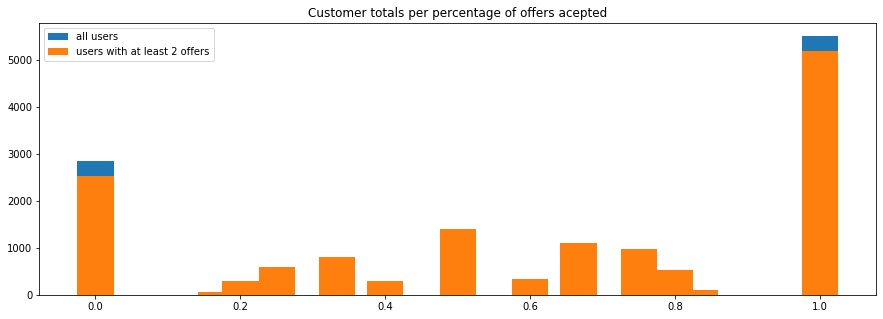

In [108]:
# We will also check the "low number effect" of users with low offer counts:

# n_offers, filters users with that number and above
# can be changed at will here:
n_offers=2

# calculi:
success_ratios = clean_profile_expanded['offer_success_ratio'].value_counts()
success_ratios2 = clean_profile_expanded[clean_profile_expanded['tot_offers_received']>=n_offers]['offer_success_ratio'].value_counts()

# graphs:
plt.bar(success_ratios.index, success_ratios, width=0.05, label='all users')
plt.bar(success_ratios2.index, success_ratios2, width=0.05, label='users with at least {} offers'.format(n_offers))
plt.legend()
plt.title('Customer totals per percentage of offers acepted');

In [109]:
clean_profile_expanded[clean_profile_expanded['tot_offers_received'] < n_offers]['offer_success_ratio'].value_counts()

1.0    316
0.0    302
Name: offer_success_ratio, dtype: int64

We also wanted to inspect how many _"lowballers"_ (people with low offer accounts, that are counted into our statistics) could have on our totals.

After this inspection, we take a modelling decision:

Ussers with acceptance values of 0.35 and and below and n_offers>1 will be assigned a 0 (non interested, do not send offers)
Ussers with acceptance values of 0.65 and above and n_offers>1 will be assigned a 1 (interested, send offers)
Ussers inbetween those values and users with n_offers=1 will be assigned a 0.5 (shelter value for the model, indecisive)

n_offers is set at 1 as the minimum, because the maximum of (non informative) offers received by a customer is 6. Going higher seemed excessive.

Now, we apply this rule to our clean_profile_expanded dataframe:

In [110]:
# Function for distributing scores in function of 'offer_success_ratio'
def scoring_fun(x):
    
    if x>0.65:
        return 1
    elif x<0.35:
        return 0
    else:
        return 0.5

# Applying function:
clean_profile_expanded['score'] = clean_profile_expanded['offer_success_ratio'].apply(scoring_fun)

# Correcting for those customers to which we didn't send enough emails:
clean_profile_expanded.loc[clean_profile_expanded['tot_offers_received']<=n_offers-1, 'score'] = 0.5

We now must drop the column used to define our client scores, and also, *'tot_offers_succesful'*, very related to it, to avoid having our target variable in our features:

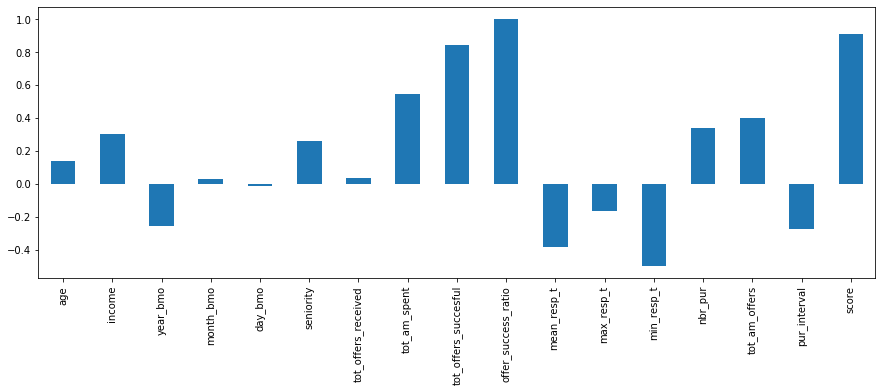

In [111]:
clean_profile_expanded.corr()['offer_success_ratio'].plot('bar')

In [112]:
# Dropping our column and the related column:
clean_profile_expanded.drop(['offer_success_ratio', 'tot_offers_succesful'], axis=1, inplace=True)

### 4.8) Passing this information to our offers table

In [113]:
total_matched_offers = pd.merge(total_matched_offers, 
                                clean_profile_expanded[['id', 'score']], 
                                on='id', 
                                how='left')

# Sanity check: as we filtered offer and transaction tables by customers we had information on, there should be no null values:
total_matched_offers[total_matched_offers['score'].isna()].shape[0]

0

### 4.9) Final touches

<img src="images/cherry.jpg" width = 400/>

Now we have our two definitive tables:
    
* clean_profile_expanded

* total_matched_offers

That will use for our models.

But before, we need to address some issues, like the nulls present still in our derived features. The moment has come that we decide on what to do with each one of them:

In [114]:
nullcols_cpe = {col:clean_profile_expanded[col].isna().sum() for col in clean_profile_expanded.columns if clean_profile_expanded[col].isna().sum()>0}
nullcols_tmo = {col:total_matched_offers[col].isna().sum() for col in total_matched_offers.columns if total_matched_offers[col].isna().sum()>0}

First we go after clean_profile_expanded:

In [115]:
nullcols_cpe

{'mean_resp_t': 2839,
 'max_resp_t': 2839,
 'min_resp_t': 2839,
 'nbr_pur': 333,
 'tot_am_offers': 61,
 'pur_interval': 652}

In [116]:
clean_profile_expanded[clean_profile_expanded['pur_interval'].isna()]['nbr_pur'].unique()

array([ 1., nan])

We decide the following:
    
**mean_resp_t, max_resp_t, min_resp_t**

Time responses to an offer. Nulls are users that never responded to offers. For our ML to make sense of these variables, we will substitute these values per the double of the maximum value found in the respective column.

**tot_am_offers:**

Users that have not performed any purchase. Seems sensible to assign them a 0.

**nbr_pur:**

Users that have not performed any purchases. 0 will be assigned.

**pur_interval:**

Users that have performed just one or no purchases, so the method previously used to determine pur_interval failed. We will segregate those users: those who have one purchase will be assigned transactions['time'].max()/2, those with no purchases will be assigned the maximum value found in the column multiplied by two.

In [117]:
cols = ['mean_resp_t', 'max_resp_t', 'min_resp_t', 'pur_interval']

for col in cols:
    val = 2 * clean_profile_expanded[col].max()
    clean_profile_expanded[col].fillna(val, inplace = True)
    
clean_profile_expanded['tot_am_offers'].fillna(0, inplace = True)
clean_profile_expanded['nbr_pur'].fillna(0, inplace = True)

clean_profile_expanded.loc[clean_profile_expanded['nbr_pur'] ==1, 'pur_interval'] = 0

In [118]:
[col for col in clean_profile_expanded.columns if clean_profile_expanded[col].isna().sum()>0]

[]

Let's see now the situation on total_matched_offers:

In [119]:
nullcols_tmo

{'time_comp': 20757, 'time_diff': 20757, 't_fr_lst_pur': 3383, 'mean_am': 3383}

Now, nulls on these columns come from left joins in which no coincidence was found.

**time_comp:**
    
Time of the offer completion. Nulls will be replaced by zeros.

**time_diff:**
    
Time difference between offer sending and its completion. As we don't know this value at the moment of sending an offer, we will drop this column. We will do that later.

**t_fr_lst_pur:**
    
Time from last purchase. If no previous purchase was performed, it will be assigned to double of the maximum found in the feature.

**mean_am:**
    
Mean ammount spent in previous purchases. 0 will be assigned.

In [120]:
total_matched_offers['time_comp'].fillna(0, inplace=True)

t_fr_lst_pur_max = total_matched_offers['t_fr_lst_pur'].max()
total_matched_offers['t_fr_lst_pur'].fillna(t_fr_lst_pur_max, inplace=True)

total_matched_offers['mean_am'].fillna(0, inplace=True)

In [121]:
[col for col in total_matched_offers.columns if total_matched_offers[col].isna().sum()>0]

['time_diff']

Finally, as we explained above, we initially decided that we would use the following code:

0 - offer received
1 - offer read
2 - offer completed

But, as we are not going to use the "viewed" information for our purposes, we decided to prescind for those values.

Now, there are currently only two values present:

0 - offer received
2 - offer completed

Those values are present in the 'event_c' (from *event completed* in our total_matched_offers dataframe:

In [122]:
total_matched_offers['event_num'].value_counts()

2.0    32444
0.0    20757
Name: event_num, dtype: int64

So, as it is more sensible, we will use the values 0 and 1 to define those states, and create an "y" column for them, as it is customary:

In [123]:
total_matched_offers['y'] = total_matched_offers['event_num'].apply(lambda x: x if x==0 else 1).astype('int')

# We now drop the original column to avoid a column in our feature space that fits EXACTLY our target variable:
total_matched_offers.drop('event_num', axis=1, inplace=True)

We will select the appropriate features from each tablel later.

Now we will save these files into our workspace:

In [124]:
path = 'treated_data'

if not os.path.exists(path):
    os.mkdir(path)

clean_profile_expanded_path = os.path.join(path, 'clean_profile_expanded.csv')
total_matched_offers_path = os.path.join(path, 'total_matched_offers.csv')

clean_profile_expanded.to_csv(clean_profile_expanded_path, sep = ';', index=False)
total_matched_offers.to_csv(total_matched_offers_path, sep = ';', index=False)